In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available.")


CUDA is available.


In [6]:
!python data/shakespeare_char/prepare.py

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


In [86]:
import numpy as np
import pickle
import os

dataset = 'shakespeare_char'
data_dir = os.path.join('data', dataset)

block_size = 1024
batch_size = 12

data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
ix = torch.randint(len(data) - block_size, (batch_size,))
X = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix]).to(torch.float32)
y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix]).to(torch.float32)

with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)

In [87]:
s = ""
for val in X[0, :].tolist():
    s += meta['itos'][val]
s

"im bring his power\nBefore sunrising, lest his son George fall\nInto the blind cave of eternal night.\nFill me a bowl of wine. Give me a watch.\nSaddle white Surrey for the field to-morrow.\nLook that my staves be sound, and not too heavy.\nRatcliff!\n\nRATCLIFF:\nMy lord?\n\nKING RICHARD III:\nSaw'st thou the melancholy Lord Northumberland?\n\nRATCLIFF:\nThomas the Earl of Surrey, and himself,\nMuch about cock-shut time, from troop to troop\nWent through the army, cheering up the soldiers.\n\nKING RICHARD III:\nSo, I am satisfied. Give me a bowl of wine:\nI have not that alacrity of spirit,\nNor cheer of mind, that I was wont to have.\nSet it down. Is ink and paper ready?\n\nRATCLIFF:\nIt is, my lord.\n\nKING RICHARD III:\nBid my guard watch; leave me.\nRatcliff, about the mid of night come to my tent\nAnd help to arm me. Leave me, I say.\n\nDERBY:\nFortune and victory sit on thy helm!\n\nRICHMOND:\nAll comfort that the dark night can afford\nBe to thy person, noble father-in-law!\nT

In [96]:
import torch
import torch.nn.functional as F

batch_size = 12
embedding_dim = 1024

# X is of shape (batch_size, embedding_dim)
X = torch.randn(batch_size, embedding_dim)

# Define weight matrices
W_Q = torch.nn.Linear(embedding_dim, embedding_dim)
W_K = torch.nn.Linear(embedding_dim, embedding_dim)
W_V = torch.nn.Linear(embedding_dim, embedding_dim)

# Compute Q, K, V
Q = W_Q(X)  # Shape: (batch_size, embedding_dim)
K = W_K(X)
V = W_V(X)

# Compute attention scores
scores = torch.matmul(Q, K.transpose(0, 1)) / torch.sqrt(torch.tensor(embedding_dim, dtype=torch.float32))  # Shape: (batch_size, batch_size)

# Apply softmax
attention_weights = F.softmax(scores, dim=-1)  # Shape: (batch_size, batch_size)

# Compute the output
output = torch.matmul(attention_weights, V)  # Shape: (batch_size, embedding_dim)

print("Output shape:", output.shape)


Output shape: torch.Size([12, 1024])


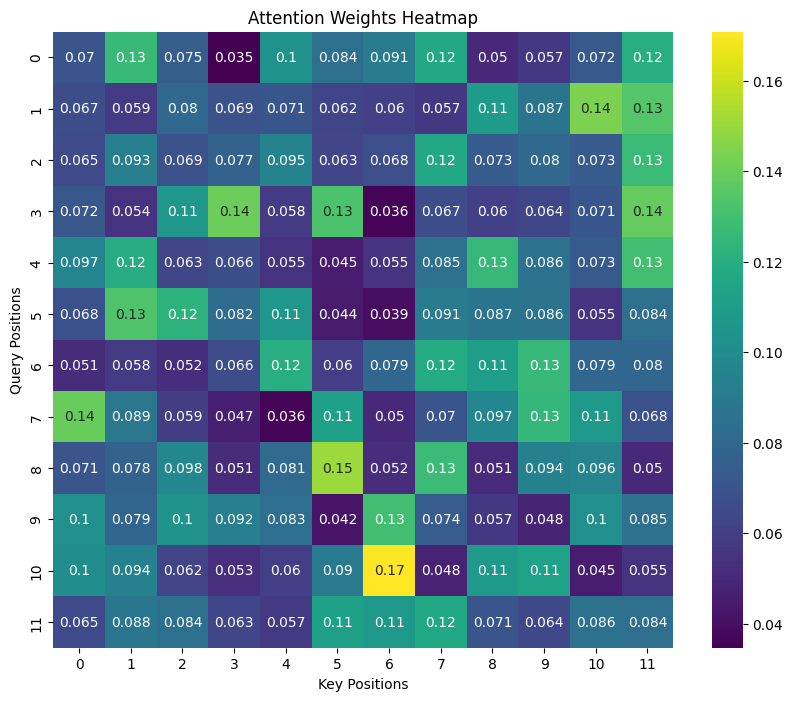

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming attention_weights is of shape (seq_length, seq_length)
attention_weights_np = attention_weights.squeeze(0).detach().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights_np, annot=True, cmap='viridis')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.title('Attention Weights Heatmap')
plt.show()


In [4]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads."

        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.linear = nn.Linear(d_model, d_model)

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        x = x.view(batch_size, seq_length, self.num_heads, self.depth)
        x = x.transpose(1, 2)  # (batch_size, num_heads, seq_length, depth)
        return x

    def forward(self, Q, K, V, mask=None):
        Q = self.W_Q(Q)
        K = self.W_K(K)
        V = self.W_V(V)

        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        scaled_attention, attention_weights = scaled_dot_product_attention(Q, K, V, mask)
        scaled_attention = scaled_attention.transpose(1, 2)  # (batch_size, seq_length, num_heads, depth)
        concat_attention = scaled_attention.reshape(Q.size(0), -1, self.num_heads * self.depth)

        output = self.linear(concat_attention)
        return output, attention_weights
